In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cuqi
from cuqi.model import Model #, LinearModel
from cuqi.geometry import MappedGeometry, Continuous1D, KLExpansion #, Geometry, Continuous
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.sampler import MH, NUTS
from scipy.linalg import lu_factor, lu_solve
import scipy as sp

import arviz

from beam_model_1D import BeamModel1D

from plot_settings import define_plot_settings

define_plot_settings(18)

np.random.seed(1)

# 1D Beam thickness estimation

<img src="./figures/448603900_1013404393461142_1134514519153019174_n.jpg" width="1000">

The Bayesian inverse problem is to infer the beam thicknesses, $\mathbf{t}$, along the beam from measurements of the beam deflections, $\mathbf{u}$. This can be formulated as

$$ \mathbf{v} = G(\mathbf{t}) + \epsilon $$

where the forward model found by solving the finite element equations:

$$ G(\mathbf{t}) = \mathbf{K}(\mathbf{t})^{-1} \mathbf{f} $$

To represent the thickness as a continuous random function, the KL expansion is introduced as:

$$ \mathbf{X} = \mu_t + \sigma \sum_{i=1}^{N_{KL}} Z_i \sqrt{\lambda_i} \mathbf{e}_i $$

where the thickness can be extracted as $\mathbf{t} = \exp({\mathbf{X}})$ to avoid negative thicknesses.

This transforms the Bayesian inverse problem to instead being a problem of inferring the coefficients, $Z_i$, i.e.

$$ \mathbf{v} = G(\mathbf{t}(Z_i)) + \epsilon $$


The noise is assummed Gaussian

$$ \epsilon \sim \mathcal{N}(0, \sigma_{obs}^2 ) $$

The likelihood function is obtained from the forward model as

$$\pi(v_{obs}|Z_i) \sim \mathcal{N}(G(\mathbf{t}(Z_i), \sigma_{obs}^2 \mathbf{I})$$

Set-up model in CUQI

In [2]:
# Data and initialization
IZ = lambda X: np.exp(X)            # Define mapping
L = 100                             # Domain length 
N_points = 99                       # Number of discretization points
nelx = N_points                     # No. of beam elements
N_KL = 5                           # Number of terms in KL expansion
grid = np.linspace(0,L,N_points)    # Discretization for domain

# Create 1D beam model
beam = BeamModel1D(nelx=nelx, L=L)
model_Beam = Model(forward=beam.forward, 
                   range_geometry=Continuous1D(grid=grid),
                   domain_geometry=MappedGeometry(KLExpansion(grid=grid,
                                                              num_modes=N_KL),
                                                              map = IZ))

# Gaussian prior: thkVec -> test it on beam domain (on Zs in KL expansion)
prior = Gaussian(0, 1, geometry=model_Beam.domain_geometry, name='Iz')

# def create_matrix(n):
#     matrix = np.zeros((n, n))
#     for i in range(n):
#         for j in range(n):
#             matrix[i, j] = (1 - ( abs(i - j)/n )*np.max(n/4.-abs(i-j),0) )**2
#     return matrix
# cov = create_matrix(N_points)
# cov = sp.sparse.diags(np.array([0.1, 0.25, 1, 0.25, 0.1]), 
#                       np.array([-2, -1, 0, 1, 2]), shape=(N_points, N_points))

Generate true signal:

/home/andfr/miniconda3/envs/clean_cookie/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


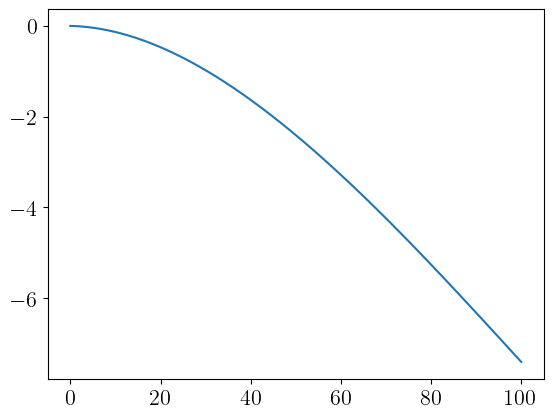

In [3]:
Zs_true = prior.sample(1)
Iz_true = Zs_true.funvals                # True beam thickness
v_true = beam.forward(Iz_true)           # True beam deflection

# Iz_true.plot()
plt.plot(grid, v_true)

/home/andfr/miniconda3/envs/clean_cookie/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Continuous1D(99,)
MappedGeometry(KLExpansion(5,))
3.997600441614789e-09


CUQI Model: MappedGeometry(KLExpansion(5,)) -> Continuous1D(99,).
    Forward parameters: ['Iz'].

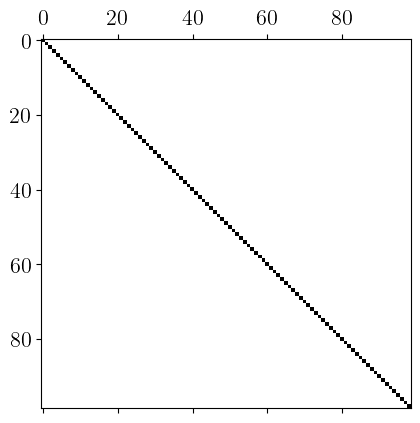

In [4]:
sigma_obs = 0.05

# Creating the covariance matrix
ell = 0.01*L
Gaussian_kernel = lambda xi1,xi2: \
    np.exp( -(xi1 - xi2)**2/(2*ell**2) ) # complete the lambda function for the Gaussian Kernel

cov = np.zeros([N_points, N_points])
for i in range(N_points):
    for j in range(N_points):
        cov[i,j] = Gaussian_kernel(grid[i], grid[j])

def cov_like(Iz):
    fx = model_Beam(Iz)[np.newaxis].T
    cov_mat = sigma_obs**2*fx**2*np.identity(N_points) #*cov
    return cov_mat

# Gaussian Likelihood: v
likelihood = cuqi.distribution.Gaussian(mean=model_Beam, 
                                        cov=cov_like, 
                                        name='v')
print(model_Beam.range_geometry)
print(model_Beam.domain_geometry)

Zs_true = prior.sample(1)
Iz_true = Zs_true.funvals                # True beam thickness
plt.spy(cov_like(Iz_true))
print(np.min(np.linalg.eigvals(cov_like(Iz_true))))
model_Beam

Create synthetic measurement data. This is acheived by obtaining first computing 'true' signal by sampling from the prior and running forward model. Then, the measurement data is obtained by adding noise to the 'true' signal.

In [5]:
epsilon = sp.stats.multivariate_normal.rvs(mean=np.zeros(N_points),
                                           cov=cov_like(Iz_true))
# plt.plot(epsilon)

Obtain measurement data

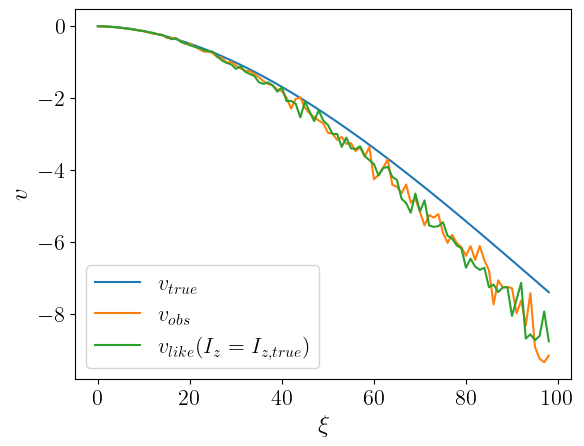

In [6]:
# Obtain measurement data by adding noise #TODO: Fix INVERSE CRIME
# v_obs = v_true + epsilon
v_obs = likelihood(Iz=Iz_true).sample(1)

# Plot true and measurement data together with likelihood function at t=t_true
plt.plot(v_true, label='$v_{true}$')
plt.plot(v_obs, label='$v_{obs}$')
likelihood(Iz=Iz_true).sample(1).plot(label='$v_{like}(I_z=I_{z,{true}})$')
plt.xlabel('$\\xi$')
plt.ylabel('$v$')
plt.legend()

Define posterior model

In [7]:
joint = JointDistribution(likelihood,prior)
posterior = joint(v=v_obs)
print(posterior)
posterior.geometry

Zs_MAP = cuqi.problem.BayesianProblem(likelihood, prior).set_data(v=v_obs).MAP()

Posterior(
    Equation:
	 p(Iz|v) ∝ L(Iz|v)p(Iz)
    Densities:
	v ~ CUQI Gaussian Likelihood function. Parameters ['Iz'].
 	Iz ~ CUQI Gaussian.
 )
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic solver selection is experimental. !!!
!!!    Always validate the computed results.    !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Optimizing with approximate gradients.
Using scipy.optimize.minimize on negative log of Posterior
x0: ones vector


/home/andfr/miniconda3/envs/clean_cookie/lib/python3.12/site-packages/cuqi/problem/_problem.py:22: SyntaxWarning: invalid escape sequence '\m'
  """ Representation of a Bayesian inverse problem defined by any number of densities (distributions and likelihoods), e.g.
/home/andfr/miniconda3/envs/clean_cookie/lib/python3.12/site-packages/cuqi/solver/_solver.py:679: SyntaxWarning: invalid escape sequence '\|'
  """(Euclidean) proximal operator of the \|x\|_1 norm.
/home/andfr/miniconda3/envs/clean_cookie/lib/python3.12/site-packages/cuqi/model/_model.py:14: SyntaxWarning: invalid escape sequence '\m'
  """Generic model defined by a forward operator.


KeyboardInterrupt: 

Sample using the Metropolis-Hastings sampler

In [ ]:
np.random.seed(10)
Ns = 1000
Z0 = Zs_true #np.ones(10)
sampler_MH = MH(posterior, x0=Z0, scale=0.4)
samples_MH = sampler_MH.sample(Ns)

/home/andfr/miniconda3/envs/clean_cookie/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Sample 1000 / 1000

Average acceptance rate: 0.325 



Sample using the No-U-turn sampler (NUTS)

In [ ]:
# NUTS Sampler
Ns = 10
posterior.enable_FD()
sampler_NUTS = NUTS(posterior, x0=Zs_true)
samples_NUTS = sampler_NUTS.sample(Ns, Nb=5)

SyntaxError: invalid syntax (246928400.py, line 4)

Compute effective sample sizes

In [ ]:
print(samples_MH.compute_ess())
# print(samples_NUTS.compute_ess())

[22.39408004 29.22028002 16.88276581  9.52402469  7.22118315  5.6768357
  2.08235619  8.38025685  2.49334135  1.85513649  4.12220123  9.98336913
 15.42994455  6.60522168 18.70476682 13.17336702 18.86681491 11.27242973
  7.59435796 12.61378667]


Plot credible intervals

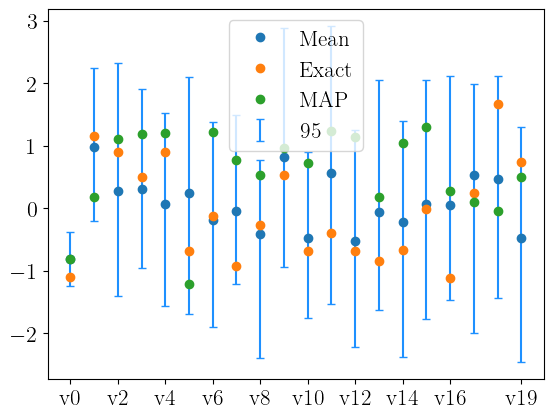

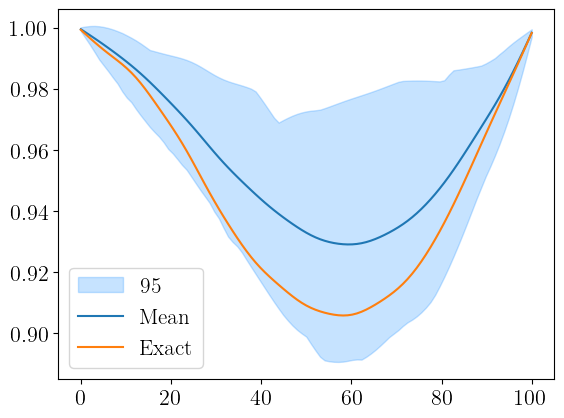

In [ ]:
samples_MH.plot_ci(plot_par=True, exact=Zs_true)
#samples_NUTS.plot_ci(plot_par=True,exact=Zs_true)
plt.plot(Zs_MAP, 'o', label='MAP')

plt.legend()

plt.figure();
samples_MH.funvals.plot_ci(plot_par=False, exact=Iz_true);
# plt.figure();

samples = samples_MH.funvals.samples.T
# arviz.plot_hdi(grid, samples, hdi_prob=0.95)
#samples_NUTS.plot_ci(plot_par=False,exact=Zs_true)

# lower, upper = np.percentile(samples, [2.5, 97.5], axis=0)
# plt.fill_between(grid,
#                 lower,
#                 upper,
#                 color='red',
#                 label=r'95\% CI',
#                 alpha=0.25)

Plot trace for a specific variable

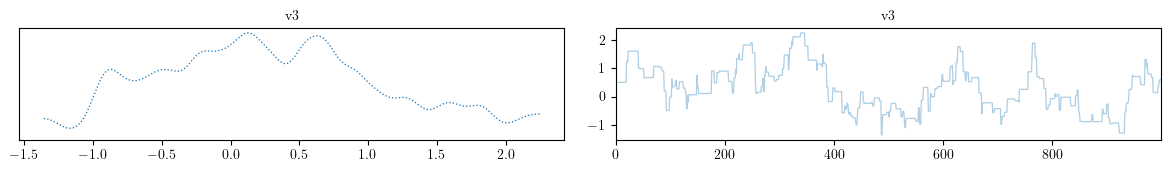

In [ ]:
# define_plot_settings(10)
samples_MH.plot_trace([3]);
# samples_MH.plot_autocorrelation()

Selecting 5 randomly chosen variables


array([[<Axes: ylabel='v17'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='v5'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='v6'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='v0', ylabel='v8'>, <Axes: xlabel='v17'>,
        <Axes: xlabel='v5'>, <Axes: xlabel='v6'>]], dtype=object)

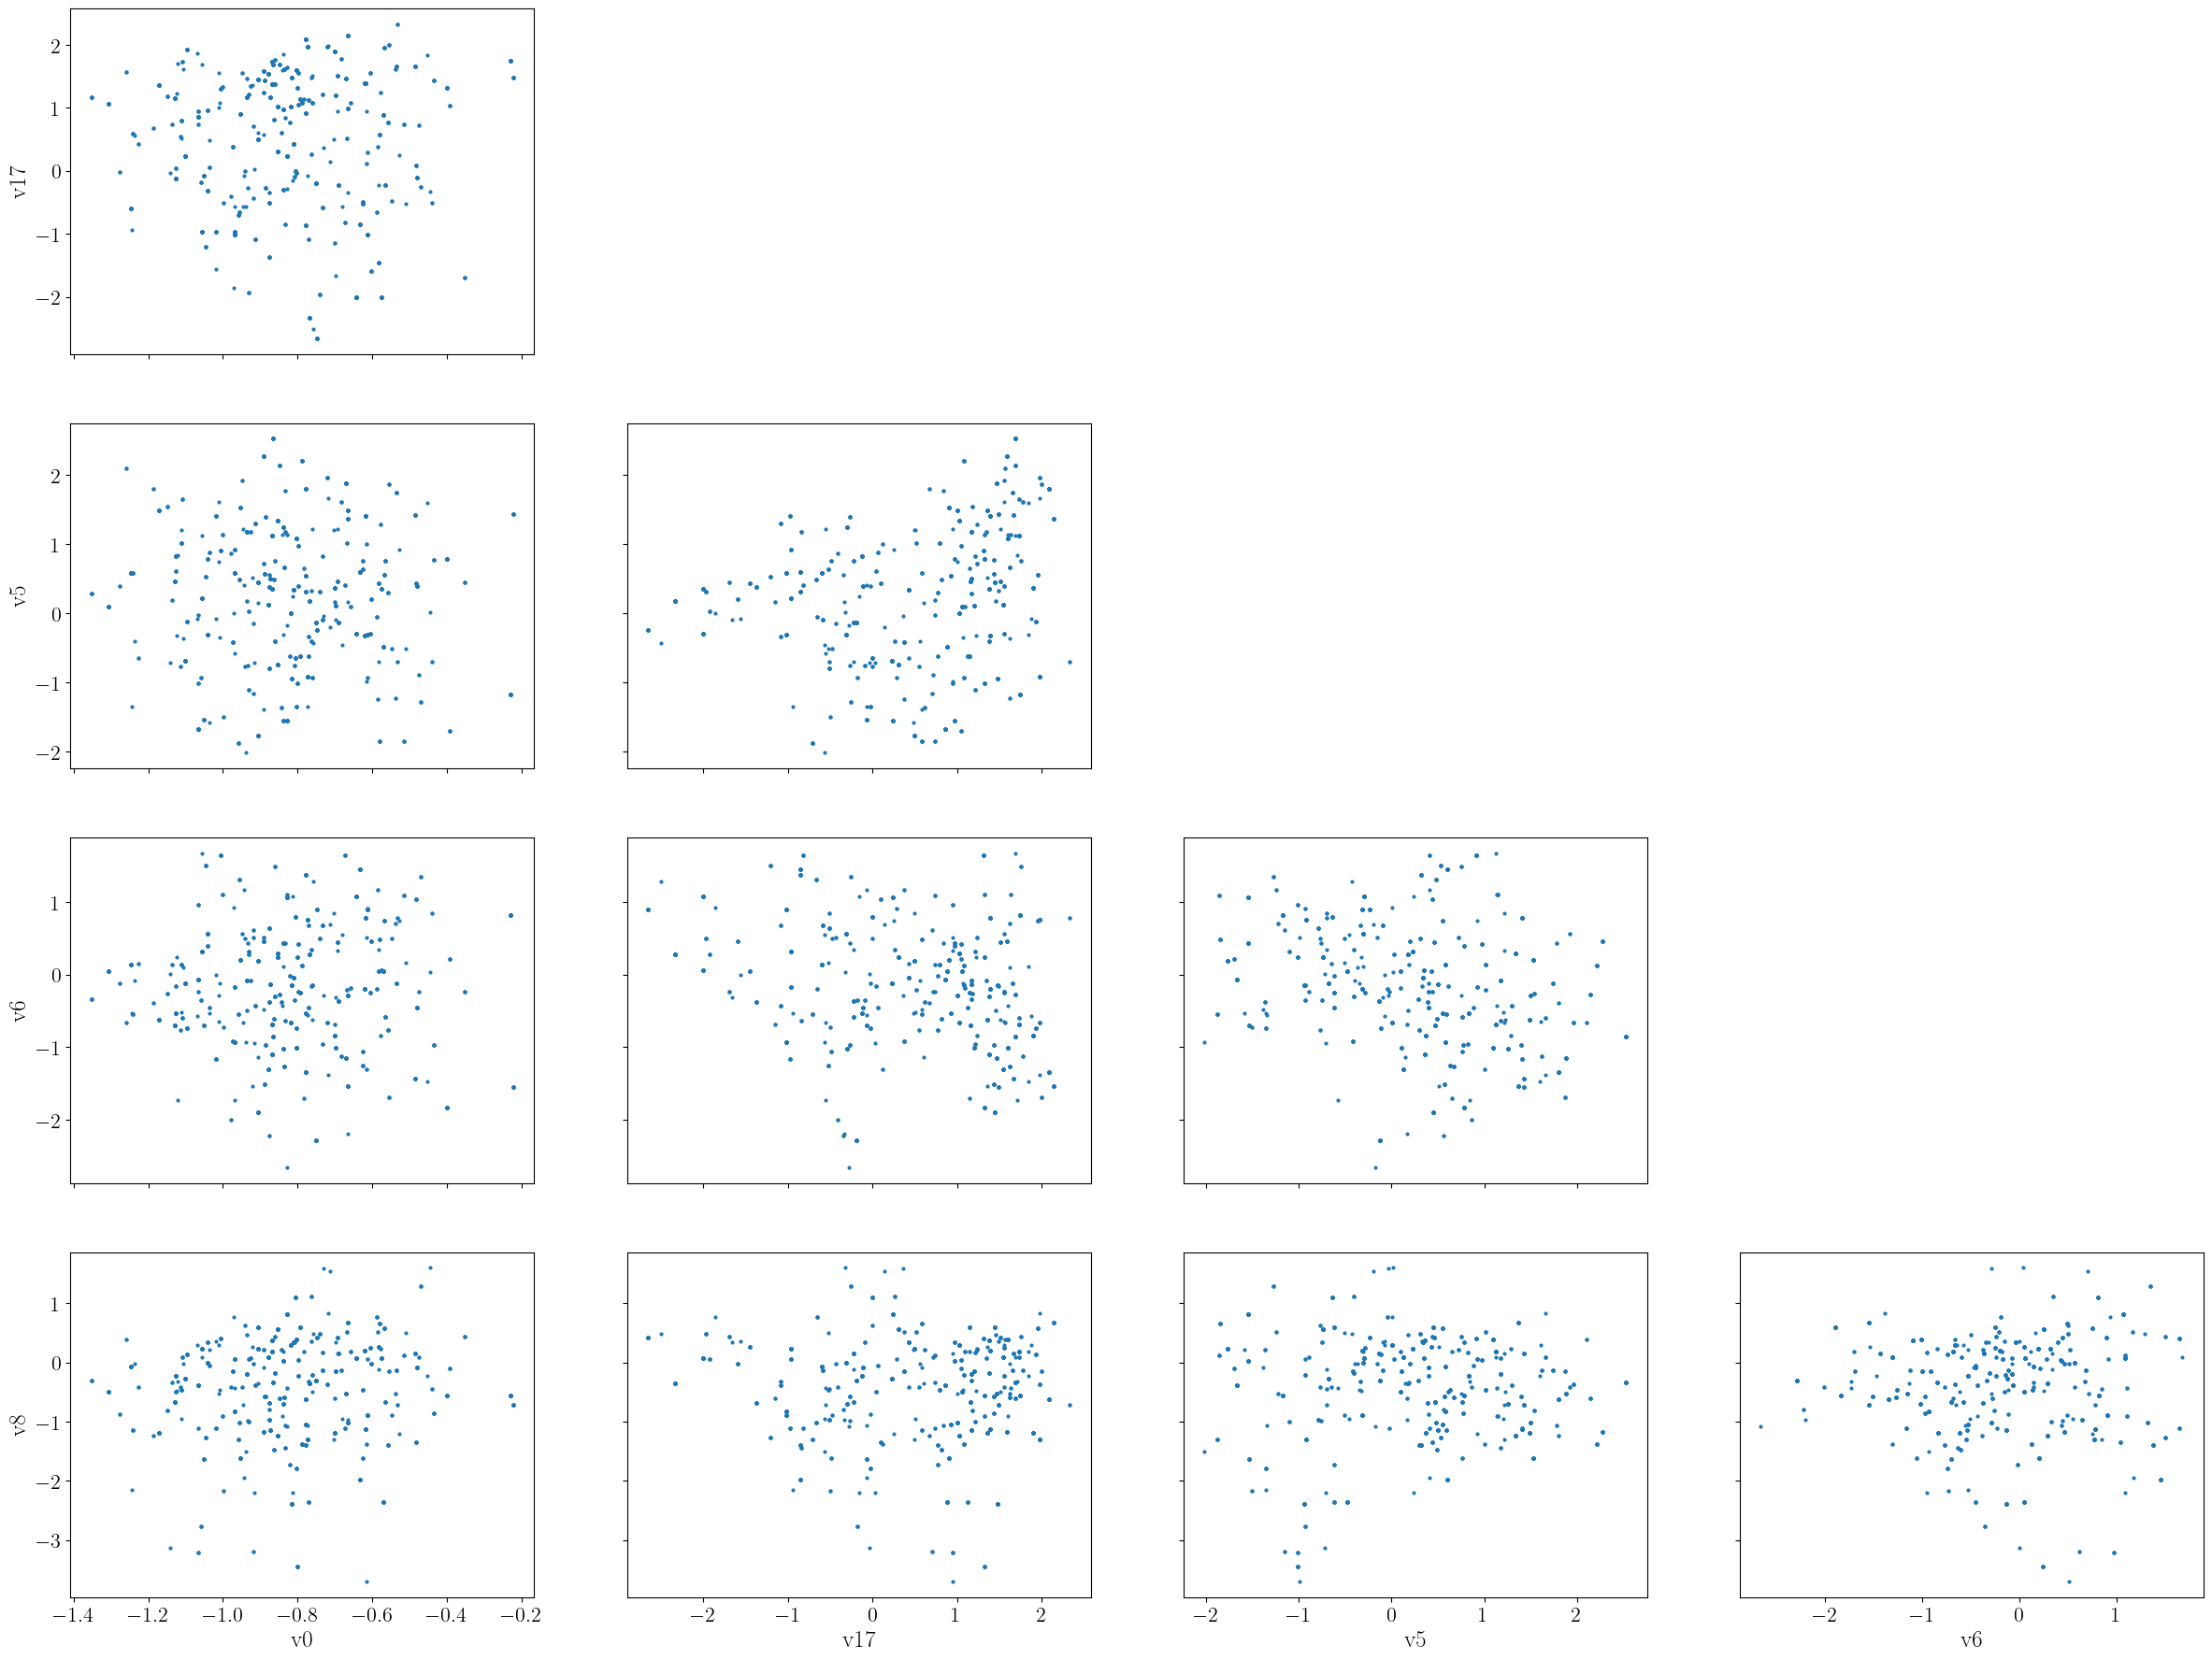

In [ ]:
samples_MH.plot_pair()

In [ ]:
sampler_NUTS.num_tree_node_list

In [ ]:
plt.plot(sampler_NUTS.num_tree_node_list)

### Analytical model:

The relation between the beam deflection, $u$, and the external forces is given by the Euler-Bernoulli beam equation:

$$ M(x) = -EI(x) \frac{d^2 v(x)}{d x^2}  $$

The bending stiffness of the beam is a product of the Young's modulus of the material, $E$, and the second moment of area, $I$. The second moment of area of a rectangular beam is related to the beam thickness by

$$ I_z = \frac{1}{12}bt^3 $$

The moment distribution for the tip load is found as 

$$ M(x) = -P(L - x) $$

Thus, the beam deflection can be found by solving the beam equation:

$$\frac{d^2 v(x)}{d x^2} =  \frac{P}{EI(x)}(L - x) $$
